# Proyek Klasifikasi Gambar: Intel Image Classification Dataset
- **Nama:** Muhammad Thariq Arya Putra Sembiring
- **Email:** mthariqaryaputra1@gmail.com
- **ID Dicoding:** [Input Username]

In [36]:
# Kaggle
import kagglehub

# Komputasi dan data
import numpy as np
import pandas as pd
import os
import glob

# Visualisasi
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# TensorFlow dan Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Evaluasi model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Konversi model
from tensorflow import lite

# Manipulasi file (optional)
import shutil
import random
from collections import defaultdict

## Data Preparation

### Download Dataset

In [2]:
# Specify the dataset name
dataset_name = "puneet6060/intel-image-classification"

# Define the destination path
destination_path = "/content/intel-image-classification"

# Download the dataset to the default Kaggle input directory
downloaded_path_default = kagglehub.dataset_download(dataset_name)
print("Dataset downloaded to default path:", downloaded_path_default)

# Copy the contents of the downloaded dataset to /content/
try:
    shutil.copytree(downloaded_path_default, destination_path)
    print(f"Copied dataset content to: {destination_path}")
except OSError as e:
    print(f"Error copying dataset: {e}")

# Reorganize folder structure
data_path = destination_path

# Get original folder paths
train_old_path = os.path.join(data_path, "seg_train/seg_train")
test_old_path = os.path.join(data_path, "seg_test/seg_test")
val_old_path = os.path.join(data_path, "seg_pred")

# Create new folder paths
train_new_path = os.path.join(data_path, "train")
val_new_path = os.path.join(data_path, "validation")
test_new_path = os.path.join(data_path, "test")

# Create new directories if they don't exist
for path in [train_new_path, val_new_path, test_new_path]:
    if not os.path.exists(path):
        os.makedirs(path)

# Copy from train_old_path to train_new_path
if os.path.exists(train_old_path):
    for class_name in os.listdir(train_old_path):
        src_class_path = os.path.join(train_old_path, class_name)
        dest_class_path = os.path.join(train_new_path, class_name)

        if os.path.isdir(src_class_path) and not os.path.exists(dest_class_path):
            shutil.copytree(src_class_path, dest_class_path)
            print(f"Copied {class_name} from train to new train folder")

# Copy from test_old_path to test_new_path
if os.path.exists(test_old_path):
    for class_name in os.listdir(test_old_path):
        src_class_path = os.path.join(test_old_path, class_name)
        dest_class_path = os.path.join(test_new_path, class_name)

        if os.path.isdir(src_class_path) and not os.path.exists(dest_class_path):
            shutil.copytree(src_class_path, dest_class_path)
            print(f"Copied {class_name} from test to new test folder")

# Create validation set from training data (since original validation set doesn't have labels)
if os.path.exists(train_new_path):
    # Get all classes
    classes = os.listdir(train_new_path)

    # For each class, move 20% of images to validation
    for class_name in classes:
        # Create class folder in validation if doesn't exist
        val_class_path = os.path.join(val_new_path, class_name)
        if not os.path.exists(val_class_path):
            os.makedirs(val_class_path)

        # Get all images in train class
        train_class_path = os.path.join(train_new_path, class_name)
        images = [f for f in os.listdir(train_class_path) if f.endswith('.jpg')]

        # Calculate number of images to move (20% of total)
        num_to_move = int(len(images) * 0.2)

        # Randomly select images to move
        images_to_move = random.sample(images, num_to_move)

        # Move images to validation
        for img in images_to_move:
            src_path = os.path.join(train_class_path, img)
            dest_path = os.path.join(val_class_path, img)
            shutil.move(src_path, dest_path)

        print(f"Moved {num_to_move} images from {class_name} to validation set")

# Print folder structure
print("\nNew folder structure:")
print(f"Train path: {train_new_path}")
print(f"Validation path: {val_new_path}")
print(f"Test path: {test_new_path}")

Dataset downloaded to default path: /kaggle/input/intel-image-classification
Copied dataset content to: /content/intel-image-classification
Copied buildings from train to new train folder
Copied sea from train to new train folder
Copied mountain from train to new train folder
Copied street from train to new train folder
Copied forest from train to new train folder
Copied glacier from train to new train folder
Copied buildings from test to new test folder
Copied sea from test to new test folder
Copied mountain from test to new test folder
Copied street from test to new test folder
Copied forest from test to new test folder
Copied glacier from test to new test folder
Moved 438 images from buildings to validation set
Moved 454 images from sea to validation set
Moved 502 images from mountain to validation set
Moved 476 images from street to validation set
Moved 454 images from forest to validation set
Moved 480 images from glacier to validation set

New folder structure:
Train path: /conte

### Data Loading

In [3]:
# Path ke folder training
train_path = "/content/intel-image-classification/train"

# Inisialisasi dictionary
class_counts = defaultdict(int)
total_images = 0

# Iterasi setiap folder kelas
for class_name in os.listdir(train_path):
    class_folder = os.path.join(train_path, class_name)
    if os.path.isdir(class_folder):
        count = len(os.listdir(class_folder))
        class_counts[class_name] = count
        total_images += count

# Tampilkan hasil
print("Jumlah gambar per kelas pada train set:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} gambar")

print("\nTotal gambar di train set:", total_images)

Jumlah gambar per kelas pada train set:
buildings: 1753 gambar
sea: 1820 gambar
mountain: 2010 gambar
street: 1906 gambar
forest: 1817 gambar
glacier: 1924 gambar

Total gambar di train set: 11230


In [4]:
# Path ke folder testing
test_path = "/content/intel-image-classification/test"

# Inisialisasi dictionary
class_counts = defaultdict(int)
total_images = 0

# Iterasi setiap folder kelas
for class_name in os.listdir(test_path):
    class_folder = os.path.join(test_path, class_name)
    if os.path.isdir(class_folder):
        count = len(os.listdir(class_folder))
        class_counts[class_name] = count
        total_images += count

# Tampilkan hasil
print("Jumlah gambar per kelas pada test set:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} gambar")

print("\nTotal gambar di test set:", total_images)

Jumlah gambar per kelas pada test set:
buildings: 437 gambar
sea: 510 gambar
mountain: 525 gambar
street: 501 gambar
forest: 474 gambar
glacier: 553 gambar

Total gambar di test set: 3000


In [5]:
# Path ke folder validation
val_path = "/content/intel-image-classification/validation"

# Inisialisasi dictionary
class_counts = defaultdict(int)
total_images = 0

# Iterasi setiap folder kelas
for class_name in os.listdir(val_path):
    class_folder = os.path.join(val_path, class_name)
    if os.path.isdir(class_folder):
        count = len(os.listdir(class_folder))
        class_counts[class_name] = count
        total_images += count

# Tampilkan hasil
print("Jumlah gambar per kelas pada validation set:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} gambar")

print("\nTotal gambar di validation set:", total_images)

Jumlah gambar per kelas pada validation set:
buildings: 438 gambar
sea: 454 gambar
mountain: 502 gambar
street: 476 gambar
forest: 454 gambar
glacier: 480 gambar

Total gambar di validation set: 2804


### Data Preprocessing

#### Check Image Size

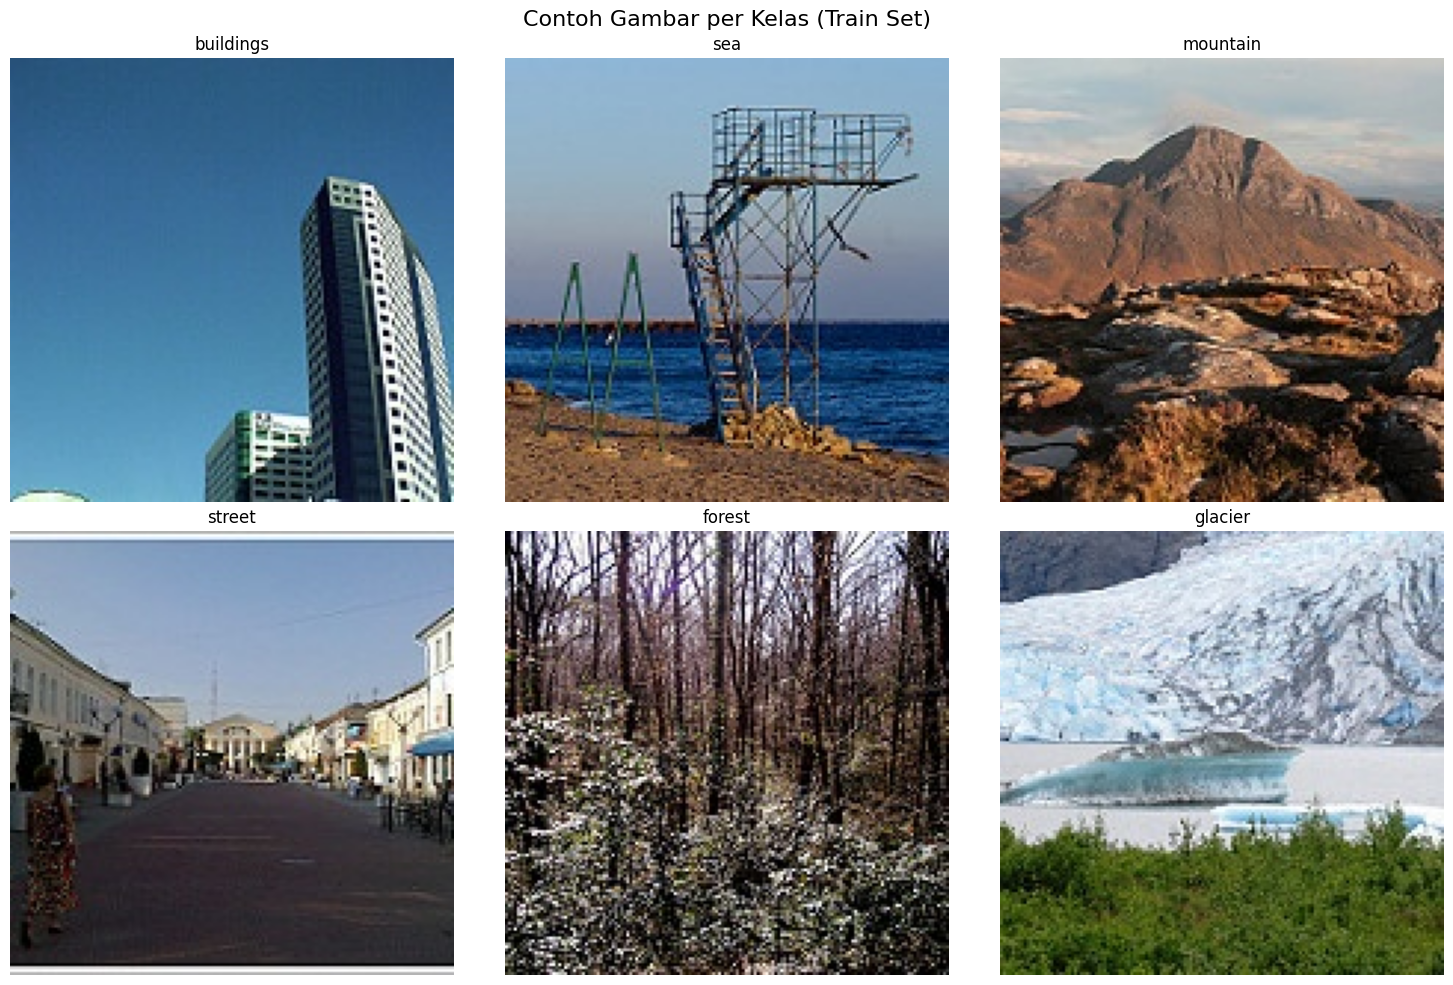

In [6]:
# Ambil daftar kelas
class_names = os.listdir(train_path)

# Plot contoh gambar dari setiap kelas
plt.figure(figsize=(15, 10))

for i, class_name in enumerate(class_names):
    class_folder = os.path.join(train_path, class_name)
    image_files = os.listdir(class_folder)

    if image_files:  # pastikan folder tidak kosong
        image_path = os.path.join(class_folder, image_files[0])
        img = mpimg.imread(image_path)

        plt.subplot(2, 3, i + 1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')

plt.suptitle("Contoh Gambar per Kelas (Train Set)", fontsize=16)
plt.tight_layout()
plt.show()

In [7]:
# Train Set
size = []

# Iterasi semua folder kelas
for folder in os.listdir(train_path):
    files = gb.glob(os.path.join(train_path, folder, "*.jpg"))
    for file in files[:50]:  # Ambil sampel 50 gambar per kelas untuk efisiensi
        image = plt.imread(file)
        size.append(image.shape)

# Hitung jumlah gambar untuk setiap ukuran
pd.Series(size).value_counts()

,count
"(150, 150, 3)",300


In [8]:
# Test Set
size = []

# Iterasi semua folder kelas
for folder in os.listdir(test_path):
    files = gb.glob(os.path.join(test_path, folder, "*.jpg"))
    for file in files[:20]:  # Ambil sampel 20 gambar per kelas untuk efisiensi
        image = plt.imread(file)
        size.append(image.shape)

# Hitung jumlah gambar untuk setiap ukuran
pd.Series(size).value_counts()

,count
"(150, 150, 3)",120


#### Resize Image to 150x150

In [9]:
# Target size gambar (meningkatkan dari 100x100 ke 150x150 agar mendapatkan detail lebih banyak)
IMG_SIZE = (150, 150)
BATCH_SIZE = 32

# Data Augmentation untuk train set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,      # Lebih banyak variasi rotasi
    zoom_range=0.2,
    width_shift_range=0.2,  # Pergeseran horizontal
    height_shift_range=0.2, # Pergeseran vertikal
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]  # Variasi kecerahan
)

# Data generator untuk validation (tanpa augmentasi)
val_datagen = ImageDataGenerator(rescale=1./255)

# Data generator untuk test (tanpa augmentasi)
test_datagen = ImageDataGenerator(rescale=1./255)

# Data generator untuk training (dengan augmentasi)
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

# Data generator untuk validation
val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Data generator untuk test
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Tampilkan informasi generator
print(f"Kelas train_generator: {train_generator.class_indices}")
print(f"Steps per epoch (train): {len(train_generator)}")
print(f"Steps per epoch (validation): {len(val_generator)}")
print(f"Steps per epoch (test): {len(test_generator)}")

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Kelas train_generator: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
Steps per epoch (train): 351
Steps per epoch (validation): 88
Steps per epoch (test): 94


#### Split Dataset and Encode Label

In [10]:
# Fungsi untuk mengubah generator jadi array
def generator_to_numpy(generator, samples=None):
    if samples is None:
        samples = len(generator) * generator.batch_size

    # Ambil batas maksimum sampel
    samples = min(samples, generator.n)

    steps = int(np.ceil(samples / generator.batch_size))
    x = []
    y = []

    for i in range(steps):
        batch = next(generator)
        x.append(batch[0])
        y.append(batch[1])

        # Jika sudah cukup, hentikan
        if (i+1) * generator.batch_size >= samples:
            break

    # Gabungkan semua batch
    x = np.concatenate(x)
    y = np.concatenate(y)

    # Potong sesuai jumlah sampel yang diinginkan
    if x.shape[0] > samples:
        x = x[:samples]
        y = y[:samples]

    return x, y

In [11]:
# Tampilkan mapping label dari setiap generator
print("Label mapping dari train_generator:", train_generator.class_indices)
print("Label mapping dari val_generator:", val_generator.class_indices)
print("Label mapping dari test_generator:", test_generator.class_indices)

Label mapping dari train_generator: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
Label mapping dari val_generator: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
Label mapping dari test_generator: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


In [12]:
# Reset generators untuk memastikan memulai dari awal
train_generator.reset()
val_generator.reset()
test_generator.reset()

# Konversi semua set ke numpy array
# Konversi dengan jumlah sampel terbatas untuk efisiensi memori
x_train, y_train = generator_to_numpy(train_generator)
x_val, y_val = generator_to_numpy(val_generator)
x_test, y_test = generator_to_numpy(test_generator)

In [13]:
# Ubah dari one-hot ke label integer
y_train_labels = np.argmax(y_train, axis=1)
y_val_labels = np.argmax(y_val, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Tampilkan ukuran dataset
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (11230, 150, 150, 3)
y_train shape: (11230, 6)
x_val shape: (2804, 150, 150, 3)
y_val shape: (2804, 6)
x_test shape: (3000, 150, 150, 3)
y_test shape: (3000, 6)


## Modelling

In [15]:
model = Sequential([
    Input(shape=(150, 150, 3)),

    # Block 1
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    # Block 2
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    # Block 3
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    # Block 4
    Conv2D(256, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(256, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    # Fully connected layers
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(6, activation='softmax')  # 6 kelas dalam dataset
])

# Tampilkan ringkasan model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 150, 150, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 75, 75, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 37, 37, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 18, 18, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 18, 18, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 11,929,382 (45.51 MB)

 Trainable params: 11,925,926 (45.49 MB)

 Non-trainable params: 3,456 (13.50 KB)

In [16]:
# Early stopping untuk menghentikan pelatihan jika tidak ada peningkatan
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Monitor akurasi validasi
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# ModelCheckpoint untuk menyimpan model terbaik
checkpoint = ModelCheckpoint(
    'best_model.h5',  # Nama file untuk model terbaik
    monitor='val_accuracy',  # Monitor akurasi validasi
    save_best_only=True,
    mode='max',
    verbose=1
)

In [17]:
# Kompilasi model dengan optimizer Adam dan learning rate yang disesuaikan
model.compile(
    loss='categorical_crossentropy',  # Untuk output one-hot encoded
    optimizer=Adam(learning_rate=0.001),  # Learning rate yang tepat
    metrics=['accuracy']
)

In [18]:
# Reset generators untuk training
train_generator.reset()
val_generator.reset()

# Latih model menggunakan generator, bukan data numpy untuk efisiensi memori
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=val_generator,
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.4122 - loss: 1.8332
Epoch 1: val_accuracy improved from -inf to 0.28923, saving model to best_model.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 127s 303ms/step - accuracy: 0.4124 - loss: 1.8324 - val_accuracy: 0.2892 - val_loss: 2.0914
Epoch 2/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.5918 - loss: 1.0814
Epoch 2: val_accuracy improved from 0.28923 to 0.42903, saving model to best_model.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 88s 251ms/step - accuracy: 0.5918 - loss: 1.0813 - val_accuracy: 0.4290 - val_loss: 1.8158
Epoch 3/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.6658 - loss: 0.9054
Epoch 3: val_accuracy improved from 0.42903 to 0.63980, saving model to best_model.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 88s 250ms/step - accuracy: 0.6658 - loss: 0.9053 - val_accuracy: 0.6398 - val_loss: 1.1028
Epoch 4/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.6987 - loss: 0.8042
Epoch 4: val_accuracy improved from 0.63980 to 0.71897, saving model to best_model.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 88s 251ms/step - accuracy: 0.6987 - loss: 0.8041 - val_accuracy: 0.7190 - val_loss: 0.7537
Epoch 5/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.7290 - loss: 0.7426
Epoch 5: val_accuracy did not improve from 0.71897
351/351 ━━━━━━━━━━━━━━━━━━━━ 87s 249ms/step - accuracy: 0.7290 - loss: 0.7426 - val_accuracy: 0.6509 - val_loss: 1.0794
Epoch 6/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.7458 - loss: 0.7025
Epoch 6: val_accuracy did not improve from 0.71897
351/351 ━━━━━━━━━━━━━━━━━━━━ 88s 252ms/step - accuracy: 0.7458 - loss: 0.7025 - val_accuracy: 0.7008 - val_loss: 0.8994
Epoch 7/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.7613 - loss: 0.6650
Epoch 7: val_accuracy did not improve from 0.71897
351/351 ━━━━━━━━━━━━━━━━━━━━ 88s 249ms/step - accuracy: 0.7613 - loss: 0.6650 - val_accuracy: 0.5489 - val_loss: 2.1786
Epoch 8/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.7680 - loss: 0.6449
Epoch 8: val_ac

351/351 ━━━━━━━━━━━━━━━━━━━━ 88s 250ms/step - accuracy: 0.7831 - loss: 0.6145 - val_accuracy: 0.7218 - val_loss: 0.8798
Epoch 10/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.7947 - loss: 0.5748
Epoch 10: val_accuracy improved from 0.72183 to 0.81562, saving model to best_model.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 88s 249ms/step - accuracy: 0.7947 - loss: 0.5748 - val_accuracy: 0.8156 - val_loss: 0.5298
Epoch 11/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.7973 - loss: 0.5778
Epoch 11: val_accuracy did not improve from 0.81562
351/351 ━━━━━━━━━━━━━━━━━━━━ 144s 254ms/step - accuracy: 0.7973 - loss: 0.5778 - val_accuracy: 0.7443 - val_loss: 0.7303
Epoch 12/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.8136 - loss: 0.5306
Epoch 12: val_accuracy did not improve from 0.81562
351/351 ━━━━━━━━━━━━━━━━━━━━ 86s 246ms/step - accuracy: 0.8135 - loss: 0.5307 - val_accuracy: 0.7254 - val_loss: 0.8367
Epoch 13/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.8035 - loss: 0.5427
Epoch 13: val_accuracy improved from 0.81562 to 0.86056, saving model to best_model.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 87s 247ms/step - accuracy: 0.8035 - loss: 0.5426 - val_accuracy: 0.8606 - val_loss: 0.4031
Epoch 14/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.8123 - loss: 0.5177
Epoch 14: val_accuracy did not improve from 0.86056
351/351 ━━━━━━━━━━━━━━━━━━━━ 86s 246ms/step - accuracy: 0.8123 - loss: 0.5177 - val_accuracy: 0.7504 - val_loss: 0.7399
Epoch 15/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.8292 - loss: 0.4916
Epoch 15: val_accuracy did not improve from 0.86056
351/351 ━━━━━━━━━━━━━━━━━━━━ 86s 246ms/step - accuracy: 0.8292 - loss: 0.4916 - val_accuracy: 0.8317 - val_loss: 0.4587
Epoch 16/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.8319 - loss: 0.4822
Epoch 16: val_accuracy did not improve from 0.86056
351/351 ━━━━━━━━━━━━━━━━━━━━ 87s 247ms/step - accuracy: 0.8319 - loss: 0.4822 - val_accuracy: 0.8424 - val_loss: 0.4447
Epoch 17/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.8420 - loss: 0.4657
Epoch 17

351/351 ━━━━━━━━━━━━━━━━━━━━ 90s 256ms/step - accuracy: 0.8420 - loss: 0.4658 - val_accuracy: 0.8613 - val_loss: 0.3924
Epoch 18/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.8394 - loss: 0.4638
Epoch 18: val_accuracy did not improve from 0.86127
351/351 ━━━━━━━━━━━━━━━━━━━━ 87s 247ms/step - accuracy: 0.8394 - loss: 0.4638 - val_accuracy: 0.8324 - val_loss: 0.4893
Epoch 19/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.8323 - loss: 0.4899
Epoch 19: val_accuracy did not improve from 0.86127
351/351 ━━━━━━━━━━━━━━━━━━━━ 87s 247ms/step - accuracy: 0.8323 - loss: 0.4898 - val_accuracy: 0.5150 - val_loss: 2.1157
Epoch 20/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.8424 - loss: 0.4500
Epoch 20: val_accuracy did not improve from 0.86127
351/351 ━━━━━━━━━━━━━━━━━━━━ 87s 248ms/step - accuracy: 0.8424 - loss: 0.4500 - val_accuracy: 0.8417 - val_loss: 0.4278
Epoch 21/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.8359 - loss: 0.4516
Epoch 21

## Evaluasi dan Visualisasi

In [19]:
# Evaluasi model pada test set
test_generator.reset()
test_loss, test_acc = model.evaluate(test_generator)
print(f"\nTest accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

# Jika akurasi test di bawah 85%, jalankan pelatihan ulang dengan parameter berbeda
if test_acc < 0.85:
    print("\nPeringatan: Akurasi test masih di bawah 85%. Disarankan untuk melatih ulang model dengan parameter berbeda.")

94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.8994 - loss: 0.3008

Test accuracy: 0.8597
Test loss: 0.4180


94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step

Laporan Klasifikasi:
              precision    recall  f1-score   support

   buildings       0.78      0.92      0.85       437
      forest       0.94      0.98      0.96       474
     glacier       0.83      0.84      0.84       553
    mountain       0.82      0.78      0.80       525
         sea       0.86      0.82      0.84       510
      street       0.94      0.83      0.88       501

    accuracy                           0.86      3000
   macro avg       0.86      0.86      0.86      3000
weighted avg       0.86      0.86      0.86      3000



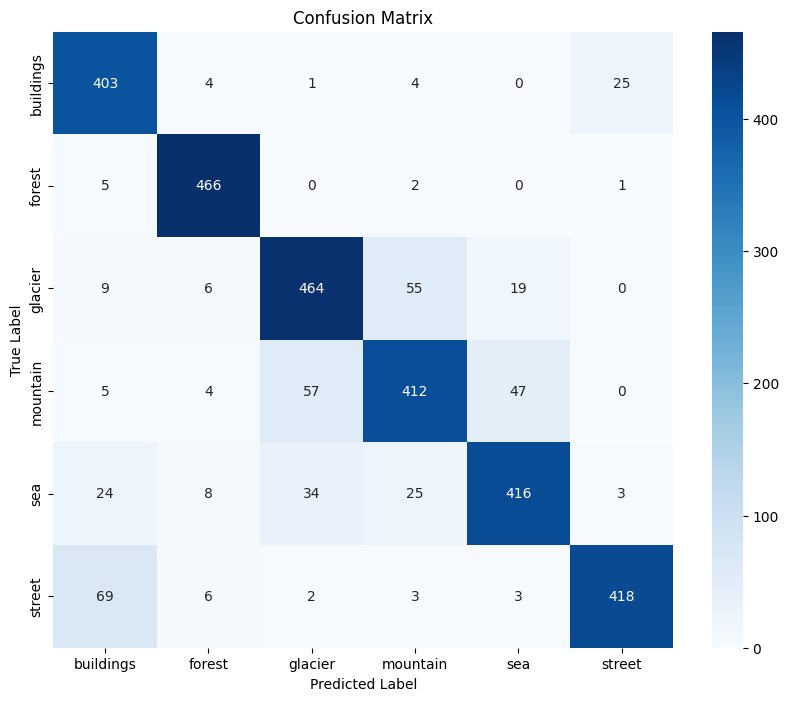

In [20]:
# Prediksi pada test set
test_generator.reset()
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert labels untuk evaluasi (ambil label yang pertama saja jika melebihi jumlah prediksi)
y_true = []
for i in range(len(test_generator)):
    batch_labels = test_generator[i][1]
    for label in batch_labels:
        y_true.append(np.argmax(label))
        if len(y_true) >= len(y_pred_classes):
            break
    if len(y_true) >= len(y_pred_classes):
        break

# Potong ke panjang yang sama
y_true = y_true[:len(y_pred_classes)]

# Kelas label
class_names = list(test_generator.class_indices.keys())

# Laporan klasifikasi
print("\nLaporan Klasifikasi:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

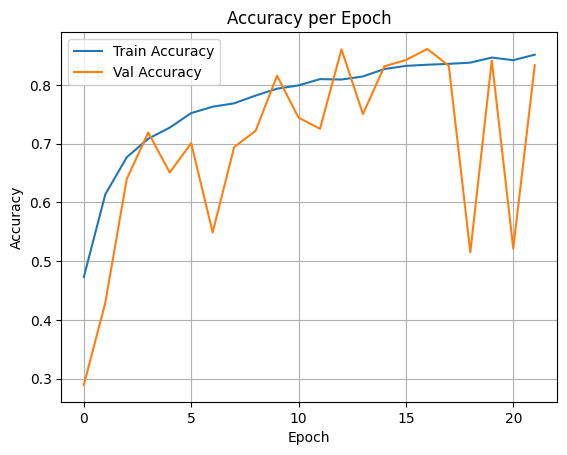

In [21]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

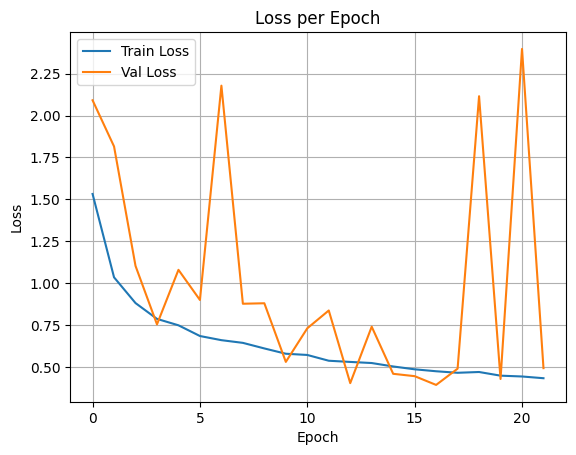

In [22]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

## Konversi Model

In [23]:
# Simpan dalam format SavedModel
model.export("model_saved")

Saved artifact at 'model_saved'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  136084624752272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136084624751120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136084621918672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136084621919056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136084624750736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136085420385360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136084621920592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136084621921168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136084621921360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136084621920208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136084621919248: Te

In [25]:
converter = tf.lite.TFLiteConverter.from_saved_model("model_saved")
tflite_model = converter.convert()

# Simpan model TFLite
with open("tflite/model.tflite", "wb") as f:
    f.write(tflite_model)

# Buat file label.txt
labels = list(train_generator.class_indices.keys())
with open("tflite/label.txt", "w") as f:
    for label in labels:
        f.write(label + "\n")

In [26]:
# TFJS
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [27]:
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    model_saved \
    tfjs_model

2025-05-15 14:47:26.656320: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747320446.676675   12857 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747320446.682831   12857 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-05-15 14:47:32.654439: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1747320452.654630   12857 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

## Inference

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


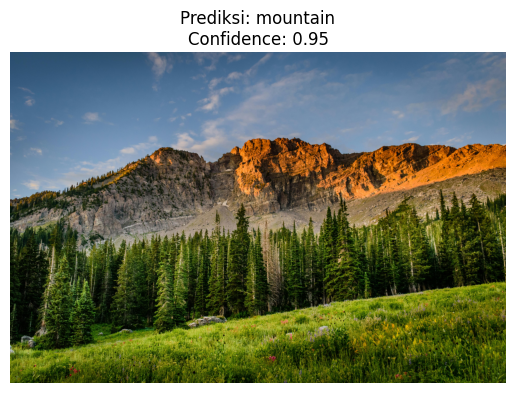

In [46]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from glob import glob

# Path
model_path = "best_model.h5"
label_path = "tflite/label.txt"
IMG_SIZE = (150, 150)

# Load label
def load_labels(path):
    with open(path, "r") as f:
        return [line.strip() for line in f]

# Fungsi prediksi
def predict(model, img_path, target_size, labels):
    # Simpan gambar asli untuk ditampilkan
    original_img = image.load_img(img_path)

    # Resize untuk prediksi
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Prediksi
    pred = model.predict(img_array)[0]
    idx = np.argmax(pred)
    class_name = labels[idx]
    confidence = pred[idx]

    return class_name, confidence, original_img

# Ambil gambar acak
image_paths = glob("test_images/*.jpg")
if not image_paths:
    raise FileNotFoundError("Tidak ada gambar di folder test_images/")
random_image_path = random.choice(image_paths)

# Load model dan prediksi
if os.path.exists(model_path) and os.path.exists(label_path):
    model = load_model(model_path)
    labels = load_labels(label_path)

    class_name, confidence, original_img = predict(model, random_image_path, IMG_SIZE, labels)

    # Tampilkan hasil dengan gambar asli
    plt.imshow(original_img)
    plt.title(f"Prediksi: {class_name}\nConfidence: {confidence:.2f}")
    plt.axis('off')
    plt.show()
else:
    print("Model atau label.txt tidak ditemukan.")